In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizer,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124
CUDA available: True


In [ ]:
# Load the data
df = pd.read_parquet('/kaggle/input/sanskrit-sentiment-classification/final_clsa_dataset.parquet')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")


Dataset loaded successfully!
Shape: (37500, 4)


In [5]:
print("Data quality checks:")
print(f"Empty Sanskrit texts: {(df['text_sanskrit'].str.strip() == '').sum()}")
print(f"Empty English texts: {(df['text_english'].str.strip() == '').sum()}")
print(f"Null Sanskrit texts: {df['text_sanskrit'].isna().sum()}")
print(f"Null English texts: {df['text_english'].isna().sum()}")

Data quality checks:
Empty Sanskrit texts: 1050
Empty English texts: 0
Null Sanskrit texts: 0
Null English texts: 0


In [6]:
initial_len = len(df)

df_clean = df.copy()
df_clean = df_clean.dropna(subset=['text_sanskrit', 'text_english'])
df_clean = df_clean[df_clean['text_sanskrit'].str.strip() != '']
df_clean = df_clean[df_clean['text_english'].str.strip() != '']

print(f"Initial samples: {initial_len}")
print(f"After cleaning: {len(df_clean)}")
print(f"Removed: {initial_len - len(df_clean)} samples")

print(f"\nLabel distribution after cleaning:")
print(df_clean['label'].value_counts())

Initial samples: 19100
After cleaning: 18050
Removed: 1050 samples

Label distribution after cleaning:
label
1    12500
2     3527
0     2023
Name: count, dtype: int64


In [7]:
# Remove any rows with missing or empty text
initial_len = len(df)

df_clean = df.copy()
df_clean = df_clean.dropna(subset=['text_sanskrit', 'text_english'])
df_clean = df_clean[df_clean['text_sanskrit'].str.strip() != '']
df_clean = df_clean[df_clean['text_english'].str.strip() != '']

print(f"Initial samples: {initial_len}")
print(f"After cleaning: {len(df_clean)}")
print(f"Removed: {initial_len - len(df_clean)} samples")

print(f"\nLabel distribution after cleaning:")
print(df_clean['label'].value_counts())

Initial samples: 37500
After cleaning: 18050
Removed: 19450 samples

Label distribution after cleaning:
label
1    12500
2     3527
0     2023
Name: count, dtype: int64


In [8]:
print("Checking splits in dataset...")
print(df_clean['split'].value_counts())

print("\nLabel distribution:")
print(df_clean['label'].value_counts())
print("\nLabel percentages:")
print(df_clean['label'].value_counts(normalize=True) * 100)

# Use existing splits
train_df = df_clean[df_clean['split'] == 'train'].reset_index(drop=True)
val_test_df = df_clean[df_clean['split'] == 'validation'].reset_index(drop=True)

print(f"\nOriginal splits:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_test_df)} samples")

# Split the validation set into val (50%) and test (50%)
from sklearn.model_selection import train_test_split

val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5,
    random_state=42,
    stratify=val_test_df['label']
)

val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"\nFinal splits:")
print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

print(f"\nLabel distribution in Train:")
print(train_df['label'].value_counts())
print(f"\nLabel distribution in Val:")
print(val_df['label'].value_counts())
print(f"\nLabel distribution in Test:")
print(test_df['label'].value_counts())

# ============================================================================
# CELL 6: Initialize Tokenizer and Test It
# ============================================================================

# Initialize XLM-RoBERTa tokenizer
MODEL_NAME = 'xlm-roberta-base'
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer loaded: {MODEL_NAME}")

# Test tokenization on a sample
sample_text = train_df['text_sanskrit'].iloc[0]
print(f"\nSample text: {sample_text[:100]}...")

# Tokenize
encoded = tokenizer(
    sample_text,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

print(f"\nTokenization successful!")
print(f"Input IDs shape: {encoded['input_ids'].shape}")
print(f"Attention mask shape: {encoded['attention_mask'].shape}")
print(f"First 10 token IDs: {encoded['input_ids'][0][:10].tolist()}")

# Test batch tokenization
batch_texts = train_df['text_sanskrit'].iloc[:3].tolist()
batch_encoded = tokenizer(
    batch_texts,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

print(f"\nBatch tokenization successful!")
print(f"Batch input IDs shape: {batch_encoded['input_ids'].shape}")


Checking splits in dataset...
split
train         14446
validation     3604
Name: count, dtype: int64

Label distribution:
label
1    12500
2     3527
0     2023
Name: count, dtype: int64

Label percentages:
label
1    69.252078
2    19.540166
0    11.207756
Name: proportion, dtype: float64

Original splits:
Train: 14446 samples
Validation: 3604 samples

Final splits:
Train: 14446 samples
Val: 1802 samples
Test: 1802 samples

Label distribution in Train:
label
1    10000
2     2806
0     1640
Name: count, dtype: int64

Label distribution in Val:
label
1    1250
2     361
0     191
Name: count, dtype: int64

Label distribution in Test:
label
1    1250
2     360
0     192
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Tokenizer loaded: xlm-roberta-base

Sample text: भवान् सायङ्काले किं करिष्यति ?...

Tokenization successful!
Input IDs shape: torch.Size([1, 128])
Attention mask shape: torch.Size([1, 128])
First 10 token IDs: [0, 10427, 95852, 107585, 44721, 51700, 109936, 1896, 3558, 55485]

Batch tokenization successful!
Batch input IDs shape: torch.Size([3, 128])


In [9]:
train_dataset = Dataset.from_pandas(train_df[['text_sanskrit', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text_sanskrit', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text_sanskrit', 'label']])

print("Datasets created!")
print(f"Train dataset: {train_dataset}")
print(f"Val dataset: {val_dataset}")
print(f"Test dataset: {test_dataset}")

print(f"\nTrain dataset columns: {train_dataset.column_names}")
print(f"Val dataset columns: {val_dataset.column_names}")
print(f"Test dataset columns: {test_dataset.column_names}")

print(f"\nFirst train sample:")
print(train_dataset[0])

Datasets created!
Train dataset: Dataset({
    features: ['text_sanskrit', 'label'],
    num_rows: 14446
})
Val dataset: Dataset({
    features: ['text_sanskrit', 'label'],
    num_rows: 1802
})
Test dataset: Dataset({
    features: ['text_sanskrit', 'label'],
    num_rows: 1802
})

Train dataset columns: ['text_sanskrit', 'label']
Val dataset columns: ['text_sanskrit', 'label']
Test dataset columns: ['text_sanskrit', 'label']

First train sample:
{'text_sanskrit': 'भवान् सायङ्काले किं करिष्यति ?', 'label': 1}


In [10]:
MAX_LENGTH = 128

def tokenize_function(examples):
    """Tokenize a batch of examples"""
    return tokenizer(
        examples['text_sanskrit'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

print("Applying tokenization...")

# Tokenize train
print("\nTokenizing train dataset...")
train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=100)
print(f"Train columns after tokenization: {train_dataset.column_names}")

# Tokenize val
print("Tokenizing val dataset...")
val_dataset = val_dataset.map(tokenize_function, batched=True, batch_size=100)
print(f"Val columns after tokenization: {val_dataset.column_names}")

# Tokenize test
print("Tokenizing test dataset...")
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=100)
print(f"Test columns after tokenization: {test_dataset.column_names}")

# Check a sample
print(f"\nSample from tokenized train dataset:")
print(f"Keys: {list(train_dataset[0].keys())}")
print(f"Input IDs length: {len(train_dataset[0]['input_ids'])}")
print(f"Label: {train_dataset[0]['label']}")

Applying tokenization...

Tokenizing train dataset...


Map:   0%|          | 0/14446 [00:00<?, ? examples/s]

Train columns after tokenization: ['text_sanskrit', 'label', 'input_ids', 'attention_mask']
Tokenizing val dataset...


Map:   0%|          | 0/1802 [00:00<?, ? examples/s]

Val columns after tokenization: ['text_sanskrit', 'label', 'input_ids', 'attention_mask']
Tokenizing test dataset...


Map:   0%|          | 0/1802 [00:00<?, ? examples/s]

Test columns after tokenization: ['text_sanskrit', 'label', 'input_ids', 'attention_mask']

Sample from tokenized train dataset:
Keys: ['text_sanskrit', 'label', 'input_ids', 'attention_mask']
Input IDs length: 128
Label: 1


In [11]:
# Remove text column (we don't need it anymore)
train_dataset = train_dataset.remove_columns(['text_sanskrit'])
val_dataset = val_dataset.remove_columns(['text_sanskrit'])
test_dataset = test_dataset.remove_columns(['text_sanskrit'])

print("Text columns removed!")
print(f"Train columns: {train_dataset.column_names}")
print(f"Val columns: {val_dataset.column_names}")
print(f"Test columns: {test_dataset.column_names}")

# Set format to PyTorch tensors
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("\nDatasets formatted as PyTorch tensors!")

# Verify
print(f"\nSample train item:")
sample = train_dataset[0]
print(f"Type: {type(sample)}")
print(f"Keys: {sample.keys()}")
print(f"Input IDs type: {type(sample['input_ids'])}")
print(f"Input IDs shape: {sample['input_ids'].shape}")

# ============================================================================
# CELL 10: Initialize the Model
# ============================================================================

# Load pre-trained model
model = XLMRobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,  # negative, neutral, positive
    problem_type="single_label_classification"
)

print(f"✓ Model loaded: {MODEL_NAME}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Model moved to: {device}")

Text columns removed!
Train columns: ['label', 'input_ids', 'attention_mask']
Val columns: ['label', 'input_ids', 'attention_mask']
Test columns: ['label', 'input_ids', 'attention_mask']

Datasets formatted as PyTorch tensors!

Sample train item:
Type: <class 'dict'>
Keys: dict_keys(['label', 'input_ids', 'attention_mask'])
Input IDs type: <class 'torch.Tensor'>
Input IDs shape: torch.Size([128])


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: xlm-roberta-base
Number of parameters: 278,045,955
Trainable parameters: 278,045,955
Model moved to: cuda


In [12]:
def compute_metrics(eval_pred):
    """Compute accuracy and F1 scores"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class imbalance detected!")
print(f"Class weights: {class_weights_dict}")
print(f"  Negative (0): {class_weights_dict[0]:.3f}")
print(f"  Neutral (1):  {class_weights_dict[1]:.3f}")
print(f"  Positive (2): {class_weights_dict[2]:.3f}")

# Convert to tensor
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float).to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results_sanskrit_clsa',
    num_train_epochs=5,  # Increased epochs for imbalanced data
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",  # Use macro F1 for imbalanced data
    greater_is_better=True,
    save_total_limit=2,
    report_to="none"
)

print("\nTraining arguments configured!")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Metric for best model: {training_args.metric_for_best_model}")

Class imbalance detected!
Class weights: {0: 2.9361788617886178, 1: 0.4815333333333333, 2: 1.7160845806604894}
  Negative (0): 2.936
  Neutral (1):  0.482
  Positive (2): 1.716

Training arguments configured!
Epochs: 5
Batch size: 16
Learning rate: 2e-05
Metric for best model: f1_macro


In [13]:
# Custom Trainer to handle class imbalance with weighted loss
from torch import nn

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Use weighted cross-entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    class_weights=class_weights_tensor,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("\n" + "="*70)

# Start training
trainer.train()

print("\n" + "="*70)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.833800,0.695410,0.701443,0.638450,0.718362
2,0.684200,0.630105,0.753052,0.690022,0.768145
3,0.578100,0.595001,0.776915,0.714540,0.788203
4,0.504600,0.605189,0.800222,0.729854,0.806494
5,0.369700,0.685518,0.788013,0.721486,0.796117


In [14]:
print("Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


Evaluating on test set...



TEST SET RESULTS
eval_loss: 0.6312
eval_accuracy: 0.7814
eval_f1_macro: 0.7161
eval_f1_weighted: 0.7888
eval_runtime: 6.1948
eval_samples_per_second: 290.8910
eval_steps_per_second: 18.2410
epoch: 5.0000



CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.5344    0.7292    0.6167       192
     Neutral     0.8974    0.7976    0.8446      1250
    Positive     0.6317    0.7528    0.6869       360

    accuracy                         0.7814      1802
   macro avg     0.6878    0.7598    0.7161      1802
weighted avg     0.8056    0.7814    0.7888      1802



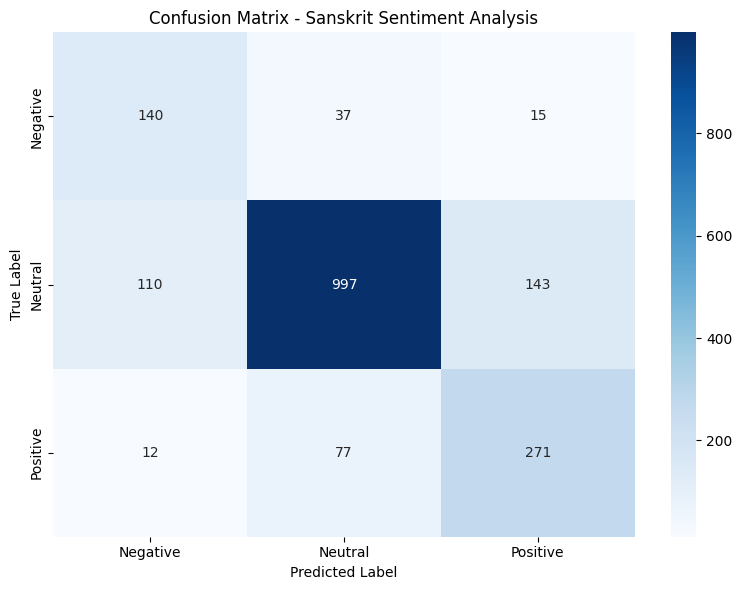


✓ Confusion matrix saved to 'confusion_matrix.png'

Total misclassified samples: 394
Accuracy: 78.14%

✓ Model and tokenizer saved to './sanskrit_sentiment_model'


In [ ]:
# Get predictions
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_df['label'].values

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(
    true_labels,
    pred_labels,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4
))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Sanskrit Sentiment Analysis')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


print(f"\nTotal misclassified samples: {len(misclassified_indices)}")
print(f"Accuracy: {(1 - len(misclassified_indices)/len(true_labels))*100:.2f}%")

save_dir = './sanskrit_sentiment_model'
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"\n✓ Model and tokenizer saved to '{save_dir}'")